# Qiskit Course - Lesson 2: Quantum Primitives with Transverse Field Ising Model (TFIM)

Welcome to Lesson 2 of our quantum computing journey! Building on our quantum coin flip foundation, we'll now explore **quantum primitives** - the core computational tools of modern quantum computing - through the fascinating physics of the **Transverse Field Ising Model (TFIM)**.

## 🚀 Installation Requirements

In [2]:
# Install required packages
!pip install qiskit[all]~=2.1.1
!pip install qiskit-aer~=0.17
!pip install qiskit-ibm-runtime~=0.41.1
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install scipy
!pip install pylatexenc

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.4 MB 4.2 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.4 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 3.9 MB/s eta 0:00:00
  Attempting uninstall: qiskit-ibm-runtime
    Found existing installation: qiskit-ibm-runtime 0.40.1
    Uninstalling qiskit-ibm-runtime-0.40.1:
      Successfully uninstalled qiskit-ibm-runtime-0.40.1


In [4]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.circuit.library import RealAmplitudes
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style for beautiful visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'font.weight': 'bold',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

## 📚 What are Quantum Primitives?

**Quantum primitives** are the fundamental building blocks of quantum computation in the NISQ (Noisy Intermediate-Scale Quantum) era. Think of them as the essential quantum "verbs" - the basic actions you can perform with quantum computers:

### **🎯 The Two Core Primitives:**

#### **1. Sampler Primitive**
- **Purpose**: Sample measurement outcomes from quantum circuits
- **Output**: Classical bit strings with their probabilities
- **Use Cases**: Random sampling, probability distribution analysis, circuit verification
- **Real-world analogy**: Like repeatedly flipping our quantum coin and recording all outcomes

#### **2. Estimator Primitive**
- **Purpose**: Calculate expectation values of quantum observables
- **Output**: Expected values of physical quantities (energy, magnetization, etc.)
- **Use Cases**: Quantum chemistry, optimization, machine learning
- **Real-world analogy**: Like measuring the average magnetization of a quantum magnet

### **🔬 Why Primitives Matter:**

In Qiskit v2.x, primitives represent a paradigm shift:
- **V1 Era**: Users had to manage low-level circuit execution details
- **V2 Era**: Primitives abstract away complexity while providing powerful flexibility
- **Modern Approach**: Focus on what you want to compute, not how to execute it

## 🧲 The Transverse Field Ising Model (TFIM): A Quantum Many-Body System

The TFIM is one of the most important models in quantum many-body physics. It describes quantum spins (like tiny magnets) that can interact with each other and with an external magnetic field.

### **🔬 The Physics Behind TFIM:**

The TFIM Hamiltonian for a 1D chain is:

\\[ H = -J \sum_{i=0}^{N-2} \sigma_i^z \sigma_{i+1}^z - B_x \sum_{i=0}^{N-1} \sigma_i^x \\]

Where:
- **J**: Coupling strength between neighboring spins (interaction energy)
- **B_x**: Transverse magnetic field strength
- **σᵢᶻ**: Pauli-Z operator on qubit i (measures spin in z-direction)
- **σᵢˣ**: Pauli-X operator on qubit i (flips spin)

### **🌟 Physical Interpretation:**

1. **Ising Term** (σᵢᶻσⱼᶻ): Neighboring spins prefer to align (↑↑ or ↓↓)
2. **Transverse Field** (σᵢˣ): External field tries to flip spins (quantum fluctuations)
3. **Competition**: Classical order (alignment) vs quantum fluctuations (flipping)

### **🎯 Why TFIM is Perfect for Quantum Computing:**

- **Quantum Phase Transition**: Shows dramatic changes between ordered and disordered phases
- **Quantum Entanglement**: Spins become entangled across the system
- **Real Materials**: Models actual magnetic materials and quantum annealing
- **Computational Challenge**: Classical computers struggle with large quantum many-body systems


In [6]:
def create_tfim_hamiltonian(num_qubits, J=1.0, Bx=0.5):
    """
    Creates the Transverse Field Ising Model Hamiltonian for a 1D chain.
    
    Parameters:
    - num_qubits: Number of qubits (spins) in the chain
    - J: Ising coupling strength (positive = ferromagnetic)
    - Bx: Transverse field strength
    
    Returns:
    - SparsePauliOp: The TFIM Hamiltonian as a quantum operator
    """
    print(f"🧲 Creating TFIM Hamiltonian:")
    print(f"   • Number of qubits: {num_qubits}")
    print(f"   • Ising coupling J: {J}")
    print(f"   • Transverse field Bx: {Bx}")
    print()
    
    # Start with empty operator
    pauli_terms = []
    
    # Add Ising interaction terms: -J * σᵢᶻσⱼᶻ for nearest neighbors
    for i in range(num_qubits - 1):
        # Create Pauli string: Z on site i and i+1, I everywhere else
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_string[i + 1] = 'Z'
        pauli_terms.append((''.join(pauli_string), -J))
        
        print(f"   • Ising term {i}-{i+1}: {''.join(pauli_string)} with coefficient {-J}")
    
    print()
    
    # Add transverse field terms: -Bx * σᵢˣ
    for i in range(num_qubits):
        # Create Pauli string: X on site i, I everywhere else
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'X'
        pauli_terms.append((''.join(pauli_string), -Bx))
        
        print(f"   • Transverse field {i}: {''.join(pauli_string)} with coefficient {-Bx}")
    
    print()
    
    # Create the SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(pauli_terms)
    
    print(f"✅ TFIM Hamiltonian created successfully!")
    print(f"   • Total terms: {len(hamiltonian.paulis)}")
    print(f"   • Expected ground state energy: approximately {estimate_ground_state_energy(num_qubits, J, Bx):.3f}")
    
    return hamiltonian

def estimate_ground_state_energy(num_qubits, J, Bx):
    """
    Estimates the ground state energy using mean-field theory.
    For the TFIM, this gives a rough approximation.
    """
    # Simple mean-field estimate for small systems
    if Bx > J:
        # Paramagnetic phase: all spins point in x-direction
        return -num_qubits * Bx
    else:
        # Ferromagnetic phase: neighboring spins align
        return -J * (num_qubits - 1) - num_qubits * Bx * (J / (J + Bx))

# Create a 4-qubit TFIM system
hamiltonian_4q = create_tfim_hamiltonian(4, J=1.0, Bx=0.5)

🧲 Creating TFIM Hamiltonian:
   • Number of qubits: 4
   • Ising coupling J: 1.0
   • Transverse field Bx: 0.5

   • Ising term 0-1: ZZII with coefficient -1.0
   • Ising term 1-2: IZZI with coefficient -1.0
   • Ising term 2-3: IIZZ with coefficient -1.0

   • Transverse field 0: XIII with coefficient -0.5
   • Transverse field 1: IXII with coefficient -0.5
   • Transverse field 2: IIXI with coefficient -0.5
   • Transverse field 3: IIIX with coefficient -0.5

✅ TFIM Hamiltonian created successfully!
   • Total terms: 7
   • Expected ground state energy: approximately -4.333


## 🎛️ Understanding the EstimatorV2 Primitive

The **EstimatorV2** primitive is our quantum tool for measuring expectation values. It answers the question: *"What is the average value of this observable when I measure this quantum state many times?"*

### **🔧 Key Features of EstimatorV2:**

- **Vectorized Input**: Can handle multiple circuits and observables efficiently
- **High Performance**: Optimized for NISQ-era quantum computing
- **Flexible Options**: Customizable precision, shots, and error mitigation
- **ISA Compatibility**: Works with Instruction Set Architecture (ISA) circuits

In [27]:
def demonstrate_estimator_basics():
    """
    Demonstrates the basic usage of EstimatorV2 primitive with simple examples.
    """
    print("🎯 EstimatorV2 Primitive Demonstration")
    print("=" * 60)
    
    # Example 1: Measuring Z expectation value of |0⟩ state
    print("\n📊 Example 1: Measuring ⟨0|Z|0⟩")
    
    # Create simple circuit in |0⟩ state
    qc_zero = QuantumCircuit(1)
    # No gates needed - starts in |0⟩
    
    # Observable: single Z operator
    obs_z = SparsePauliOp.from_list([('Z', 1.0)])
    
    # Create local estimator using Aer
    estimator = AerEstimator()
    
    # Run estimation
    job = estimator.run([(qc_zero, obs_z)])
    result = job.result()
    expectation_value = float(result[0].data.evs)  # Works for single measurements

    
    print(f"   • Circuit: |0⟩ state")
    print(f"   • Observable: Z operator")
    print(f"   • Expected result: +1.0 (|0⟩ is +1 eigenstate of Z)")
    print(f"   • Computed result: {expectation_value:.6f}")
    print(f"   • ✅ {'PASS' if abs(expectation_value - 1.0) < 1e-10 else 'FAIL'}")
    
    # Example 2: Measuring Z expectation value of |1⟩ state
    print("\n📊 Example 2: Measuring ⟨1|Z|1⟩")
    
    # Create circuit in |1⟩ state
    qc_one = QuantumCircuit(1)
    qc_one.x(0)  # Apply X gate to flip |0⟩ → |1⟩
    
    job = estimator.run([(qc_one, obs_z)])
    result = job.result()
    expectation_value = float(result[0].data.evs)  # Works for single measurements
    
    print(f"   • Circuit: X|0⟩ = |1⟩ state")
    print(f"   • Observable: Z operator")
    print(f"   • Expected result: -1.0 (|1⟩ is -1 eigenstate of Z)")
    print(f"   • Computed result: {expectation_value:.6f}")
    print(f"   • ✅ {'PASS' if abs(expectation_value + 1.0) < 1e-10 else 'FAIL'}")
    
    # Example 3: Measuring X expectation value of superposition state
    print("\n📊 Example 3: Measuring ⟨+|X|+⟩")
    
    # Create superposition state |+⟩ = (|0⟩ + |1⟩)/√2
    qc_plus = QuantumCircuit(1)
    qc_plus.h(0)  # Hadamard creates superposition
    
    # Observable: single X operator
    obs_x = SparsePauliOp.from_list([('X', 1.0)])
    
    job = estimator.run([(qc_plus, obs_x)])
    result = job.result()
    expectation_value = float(result[0].data.evs)  # Works for single measurements
    
    print(f"   • Circuit: H|0⟩ = |+⟩ state")
    print(f"   • Observable: X operator")
    print(f"   • Expected result: +1.0 (|+⟩ is +1 eigenstate of X)")
    print(f"   • Computed result: {expectation_value:.6f}")
    print(f"   • ✅ {'PASS' if abs(expectation_value - 1.0) < 1e-10 else 'FAIL'}")
    
    print("\n🎓 Key Insights:")
    print("   • Estimator computes ⟨ψ|O|ψ⟩ for quantum state |ψ⟩ and observable O")
    print("   • Results are exact for statevector simulation (no shot noise)")
    print("   • Each eigenstate gives the corresponding eigenvalue as expectation")
    print("   • Superposition states can have non-trivial expectation values")

demonstrate_estimator_basics()

🎯 EstimatorV2 Primitive Demonstration

📊 Example 1: Measuring ⟨0|Z|0⟩
   • Circuit: |0⟩ state
   • Observable: Z operator
   • Expected result: +1.0 (|0⟩ is +1 eigenstate of Z)
   • Computed result: 1.000000
   • ✅ PASS

📊 Example 2: Measuring ⟨1|Z|1⟩
   • Circuit: X|0⟩ = |1⟩ state
   • Observable: Z operator
   • Expected result: -1.0 (|1⟩ is -1 eigenstate of Z)
   • Computed result: -1.000000
   • ✅ PASS

📊 Example 3: Measuring ⟨+|X|+⟩
   • Circuit: H|0⟩ = |+⟩ state
   • Observable: X operator
   • Expected result: +1.0 (|+⟩ is +1 eigenstate of X)
   • Computed result: 1.000000
   • ✅ PASS

🎓 Key Insights:
   • Estimator computes ⟨ψ|O|ψ⟩ for quantum state |ψ⟩ and observable O
   • Results are exact for statevector simulation (no shot noise)
   • Each eigenstate gives the corresponding eigenvalue as expectation
   • Superposition states can have non-trivial expectation values


## 🧪 Creating Quantum States for TFIM Studies

To study the TFIM, we need to prepare interesting quantum states. Let's create both simple product states and entangled states.

In [31]:
def create_tfim_test_states(num_qubits):
    """
    Creates various quantum states useful for TFIM studies.
    
    Returns dictionary of circuits with descriptive names.
    """
    states = {}
    
    # 1. All spins up (|00...0⟩) - Classical ferromagnetic state
    qc_all_up = QuantumCircuit(num_qubits)
    # No gates needed - starts in |00...0⟩
    states['all_up'] = qc_all_up
    
    # 2. All spins down (|11...1⟩) - Classical antiferromagnetic state
    qc_all_down = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc_all_down.x(i)
    states['all_down'] = qc_all_down
    
    # 3. Néel state (|0101...⟩) - Classical antiferromagnetic order
    qc_neel = QuantumCircuit(num_qubits)
    for i in range(1, num_qubits, 2):  # Apply X to odd sites
        qc_neel.x(i)
    states['neel'] = qc_neel
    
    # 4. Superposition state (|++++...⟩) - All spins in x-eigenstate
    qc_superposition = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc_superposition.h(i)  # Each qubit in |+⟩ = (|0⟩ + |1⟩)/√2
    states['all_plus'] = qc_superposition
    
    # 5. GHZ state - Maximally entangled state
    qc_ghz = QuantumCircuit(num_qubits)
    qc_ghz.h(0)  # Create superposition on first qubit
    for i in range(1, num_qubits):
        qc_ghz.cx(0, i)  # Entangle all other qubits with first
    states['ghz'] = qc_ghz
    
    # 6. Random parameterized state using RealAmplitudes ansatz
    qc_variational = RealAmplitudes(num_qubits, reps=2)
    # Set some example parameters
    np.random.seed(42)  # For reproducibility
    params = np.random.uniform(0, 2*np.pi, qc_variational.num_parameters)
    qc_variational = qc_variational.assign_parameters(params)
    
    # 🔧 FIX: Decompose the RealAmplitudes circuit into basic gates
    qc_variational = qc_variational.decompose()
    
    states['variational'] = qc_variational
    
    return states

def visualize_states(states):
    """
    Visualizes the quantum states and their properties.
    """
    print("🌟 Quantum States for TFIM Studies")
    print("=" * 60)
    
    for name, circuit in states.items():
        print(f"\n📊 {name.upper()} STATE:")
        
        # Get statevector
        statevector = Statevector.from_instruction(circuit)
        
        # Calculate some properties
        num_qubits = circuit.num_qubits
        
        print(f"   • Circuit depth: {circuit.depth()}")
        print(f"   • Number of gates: {sum(circuit.count_ops().values())}")
        
        # For small systems, show full statevector
        if num_qubits <= 3:
            print(f"   • Statevector: {statevector.data}")
            # Show probabilities
            probs = statevector.probabilities()
            for i, prob in enumerate(probs):
                if prob > 1e-10:  # Only show non-zero probabilities
                    binary_state = format(i, f'0{num_qubits}b')
                    print(f"     |{binary_state}⟩: {prob:.4f}")
        else:
            # For larger systems, show summary statistics
            probs = statevector.probabilities()
            max_prob = np.max(probs)
            max_state = np.argmax(probs)
            binary_max = format(max_state, f'0{num_qubits}b')
            print(f"   • Most probable state: |{binary_max}⟩ with probability {max_prob:.4f}")
            print(f"   • Entropy: {statevector.entropy():.4f}")

# Create and visualize states for 3-qubit system
states_3q = create_tfim_test_states(3)
visualize_states(states_3q)

🌟 Quantum States for TFIM Studies

📊 ALL_UP STATE:
   • Circuit depth: 0
   • Number of gates: 0
   • Statevector: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
     |000⟩: 1.0000

📊 ALL_DOWN STATE:
   • Circuit depth: 1
   • Number of gates: 3
   • Statevector: [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
     |111⟩: 1.0000

📊 NEEL STATE:
   • Circuit depth: 1
   • Number of gates: 1
   • Statevector: [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
     |010⟩: 1.0000

📊 ALL_PLUS STATE:
   • Circuit depth: 1
   • Number of gates: 3
   • Statevector: [0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
     |000⟩: 0.1250
     |001⟩: 0.1250
     |010⟩: 0.1250
     |011⟩: 0.1250
     |100⟩: 0.1250
     |101⟩: 0.1250
     |110⟩: 0.1250
     |111⟩: 0.1250

📊 GHZ STATE:
   • Circuit depth: 3
   • Number of gates: 3
   • Statevector: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        

## 📊 Measuring TFIM Observables with EstimatorV2

Now let's use the EstimatorV2 primitive to measure physical observables in our TFIM system. This is where quantum computing shows its power - we can directly measure quantum many-body properties!

In [32]:
def measure_tfim_observables(states, hamiltonian, num_qubits):
    """
    Measures various TFIM observables for different quantum states.
    
    This demonstrates the power of the EstimatorV2 primitive for quantum many-body physics.
    """
    print("🔬 TFIM Observable Measurements using EstimatorV2")
    print("=" * 70)
    
    # Create estimator
    estimator = AerEstimator()
    
    # Define observables of interest
    observables = {}
    
    # 1. Energy (Hamiltonian expectation value)
    observables['Energy'] = hamiltonian
    
    # 2. Total magnetization in Z direction
    z_terms = []
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        z_terms.append((''.join(pauli_string), 1.0))
    observables['Magnetization_Z'] = SparsePauliOp.from_list(z_terms)
    
    # 3. Total magnetization in X direction
    x_terms = []
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'X'
        x_terms.append((''.join(pauli_string), 1.0))
    observables['Magnetization_X'] = SparsePauliOp.from_list(x_terms)
    
    # 4. Nearest neighbor correlations ⟨ZᵢZⱼ⟩
    zz_terms = []
    for i in range(num_qubits - 1):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_string[i + 1] = 'Z'
        zz_terms.append((''.join(pauli_string), 1.0))
    observables['ZZ_Correlations'] = SparsePauliOp.from_list(zz_terms)
    
    # Store results
    results = {}
    
    # Measure all observables for all states
    for state_name, circuit in states.items():
        print(f"\n🎯 STATE: {state_name.upper()}")
        print("-" * 40)
        
        state_results = {}
        
        for obs_name, observable in observables.items():
            # Run estimation
            job = estimator.run([(circuit, observable)])
            result = job.result()
            expectation_value = float(result[0].data.evs)  # Works for single measurements
            
            state_results[obs_name] = expectation_value
            
            print(f"   • {obs_name:15s}: {expectation_value:8.4f}")
        
        results[state_name] = state_results
        
        # Physical interpretation
        print(f"   🧠 Interpretation:")
        if state_results['Energy'] < -0.5 * num_qubits:
            print(f"      → Low energy state (stable configuration)")
        else:
            print(f"      → High energy state (excited configuration)")
            
        if abs(state_results['Magnetization_Z']) > 0.5 * num_qubits:
            print(f"      → Magnetically ordered in Z direction")
        elif abs(state_results['Magnetization_X']) > 0.5 * num_qubits:
            print(f"      → Magnetically ordered in X direction")
        else:
            print(f"      → Magnetically disordered")
    
    return results
# Measure observables for 3-qubit TFIM
hamiltonian_3q = create_tfim_hamiltonian(3, J=1.0, Bx=0.5)
results_3q = measure_tfim_observables(states_3q, hamiltonian_3q, 3)

🧲 Creating TFIM Hamiltonian:
   • Number of qubits: 3
   • Ising coupling J: 1.0
   • Transverse field Bx: 0.5

   • Ising term 0-1: ZZI with coefficient -1.0
   • Ising term 1-2: IZZ with coefficient -1.0

   • Transverse field 0: XII with coefficient -0.5
   • Transverse field 1: IXI with coefficient -0.5
   • Transverse field 2: IIX with coefficient -0.5

✅ TFIM Hamiltonian created successfully!
   • Total terms: 5
   • Expected ground state energy: approximately -3.000
🔬 TFIM Observable Measurements using EstimatorV2

🎯 STATE: ALL_UP
----------------------------------------
   • Energy         :  -2.0000
   • Magnetization_Z:   3.0000
   • Magnetization_X:   0.0000
   • ZZ_Correlations:   2.0000
   🧠 Interpretation:
      → Low energy state (stable configuration)
      → Magnetically ordered in Z direction

🎯 STATE: ALL_DOWN
----------------------------------------
   • Energy         :  -2.0000
   • Magnetization_Z:  -3.0000
   • Magnetization_X:   0.0000
   • ZZ_Correlations:   2


## 🎨 Beautiful Visualization of TFIM Results

Let's create stunning visualizations to understand our TFIM measurements better.


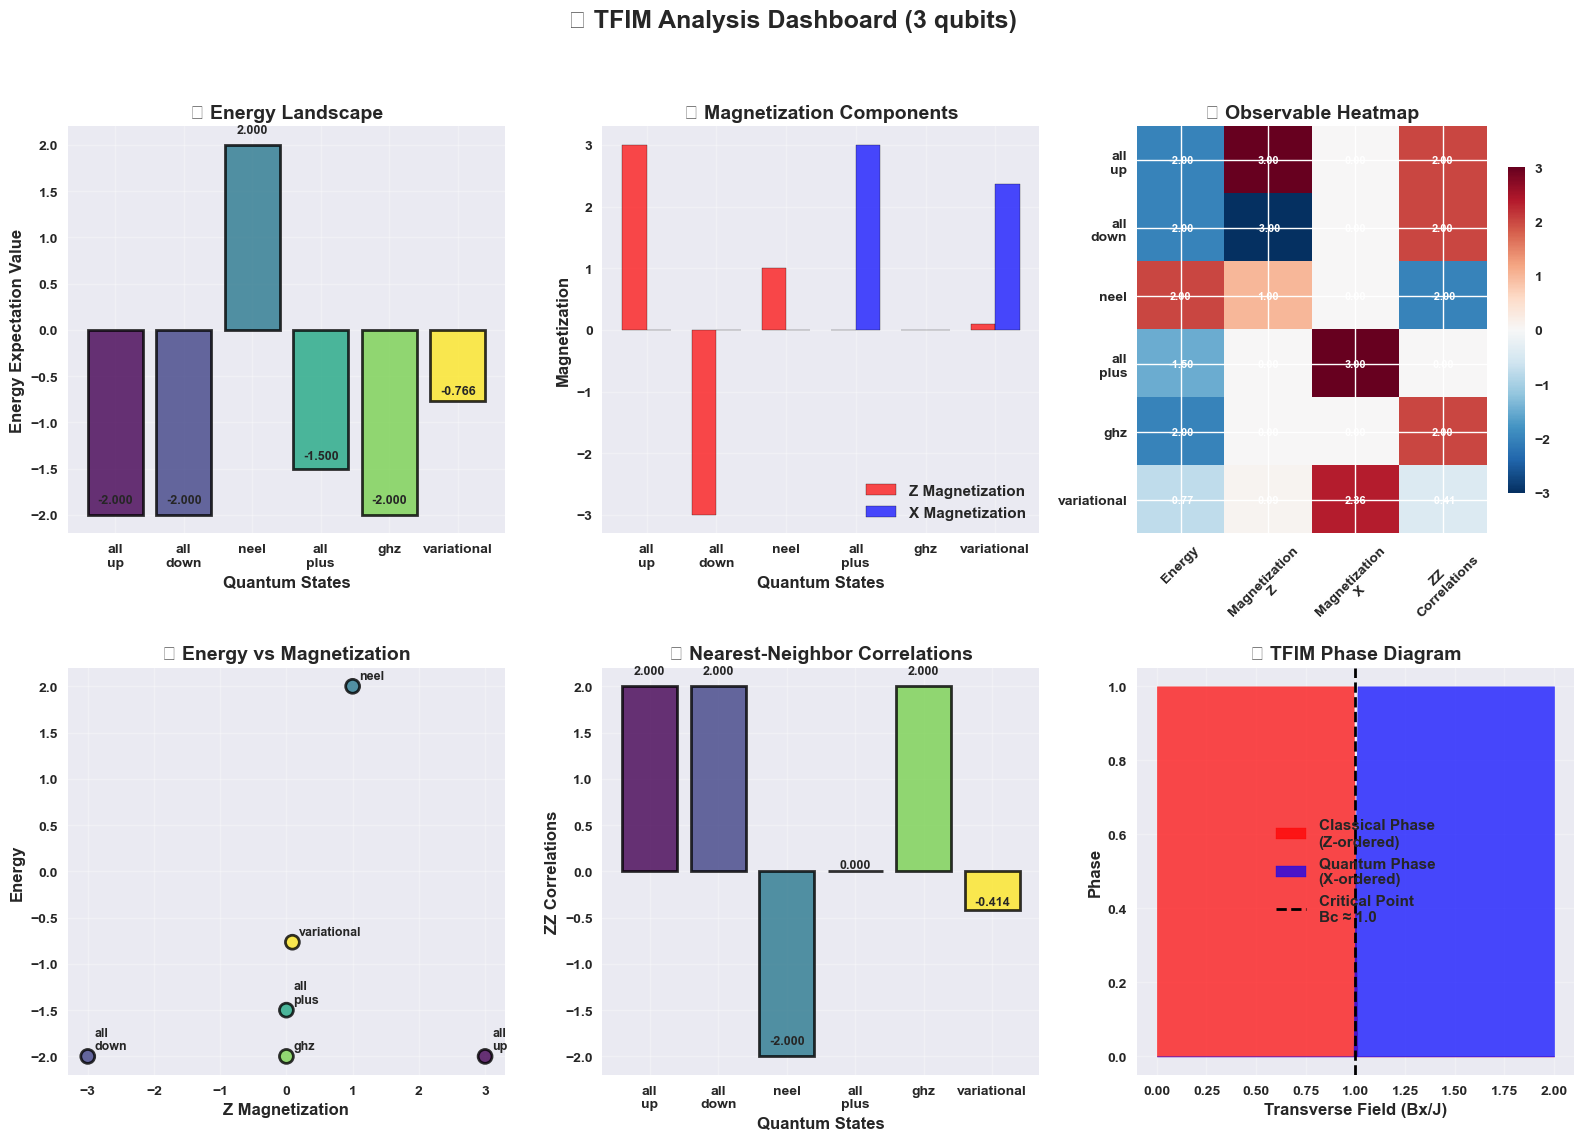

In [33]:
def create_tfim_visualization_dashboard(results, num_qubits):
    """
    Creates a comprehensive dashboard visualizing TFIM measurement results.
    """
    # Prepare data for plotting
    state_names = list(results.keys())
    observables = list(next(iter(results.values())).keys())
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Energy comparison bar chart
    ax1 = plt.subplot(2, 3, 1)
    energies = [results[state]['Energy'] for state in state_names]
    colors = plt.cm.viridis(np.linspace(0, 1, len(state_names)))
    
    bars = ax1.bar(range(len(state_names)), energies, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=2)
    ax1.set_xlabel('Quantum States', fontweight='bold')
    ax1.set_ylabel('Energy Expectation Value', fontweight='bold')
    ax1.set_title('🔋 Energy Landscape', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(state_names)))
    ax1.set_xticklabels([name.replace('_', '\n') for name in state_names], 
                        rotation=0, fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Add energy values on bars
    for bar, energy in zip(bars, energies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05*abs(height),
                f'{energy:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 2. Magnetization comparison
    ax2 = plt.subplot(2, 3, 2)
    mag_z = [results[state]['Magnetization_Z'] for state in state_names]
    mag_x = [results[state]['Magnetization_X'] for state in state_names]
    
    x = np.arange(len(state_names))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, mag_z, width, label='Z Magnetization', 
                    color='red', alpha=0.7, edgecolor='black')
    bars2 = ax2.bar(x + width/2, mag_x, width, label='X Magnetization', 
                    color='blue', alpha=0.7, edgecolor='black')
    
    ax2.set_xlabel('Quantum States', fontweight='bold')
    ax2.set_ylabel('Magnetization', fontweight='bold')
    ax2.set_title('🧲 Magnetization Components', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([name.replace('_', '\n') for name in state_names], 
                        rotation=0, fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Observable heatmap
    ax3 = plt.subplot(2, 3, 3)
    
    # Create data matrix
    data_matrix = []
    for state in state_names:
        row = [results[state][obs] for obs in observables]
        data_matrix.append(row)
    
    data_matrix = np.array(data_matrix)
    
    im = ax3.imshow(data_matrix, cmap='RdBu_r', aspect='auto')
    ax3.set_xticks(range(len(observables)))
    ax3.set_xticklabels([obs.replace('_', '\n') for obs in observables], 
                        rotation=45, fontsize=10)
    ax3.set_yticks(range(len(state_names)))
    ax3.set_yticklabels([name.replace('_', '\n') for name in state_names], 
                        fontsize=10)
    ax3.set_title('🌈 Observable Heatmap', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(state_names)):
        for j in range(len(observables)):
            text = ax3.text(j, i, f'{data_matrix[i, j]:.2f}',
                           ha="center", va="center", color="white", 
                           fontweight='bold', fontsize=8)
    
    plt.colorbar(im, ax=ax3, shrink=0.8)
    
    # 4. Energy vs Magnetization scatter plot
    ax4 = plt.subplot(2, 3, 4)
    
    scatter = ax4.scatter(mag_z, energies, c=colors, s=100, alpha=0.8, 
                         edgecolors='black', linewidth=2)
    
    # Add state labels
    for i, state in enumerate(state_names):
        ax4.annotate(state.replace('_', '\n'), (mag_z[i], energies[i]),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, fontweight='bold')
    
    ax4.set_xlabel('Z Magnetization', fontweight='bold')
    ax4.set_ylabel('Energy', fontweight='bold')
    ax4.set_title('⚡ Energy vs Magnetization', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Correlation analysis
    ax5 = plt.subplot(2, 3, 5)
    correlations = [results[state]['ZZ_Correlations'] for state in state_names]
    
    bars = ax5.bar(range(len(state_names)), correlations, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=2)
    ax5.set_xlabel('Quantum States', fontweight='bold')
    ax5.set_ylabel('ZZ Correlations', fontweight='bold')
    ax5.set_title('🔗 Nearest-Neighbor Correlations', fontsize=14, fontweight='bold')
    ax5.set_xticks(range(len(state_names)))
    ax5.set_xticklabels([name.replace('_', '\n') for name in state_names], 
                        rotation=0, fontsize=10)
    ax5.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, corr in zip(bars, correlations):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.05*abs(height),
                f'{corr:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 6. Quantum phase diagram insight
    ax6 = plt.subplot(2, 3, 6)
    
    # Create a simple phase diagram illustration
    B_range = np.linspace(0, 2, 100)
    J_fixed = 1.0
    
    # Critical field for TFIM: Bc = J for infinite system
    critical_field = J_fixed
    
    phase_classical = np.where(B_range < critical_field, 1, 0)
    phase_quantum = np.where(B_range >= critical_field, 1, 0)
    
    ax6.fill_between(B_range, 0, phase_classical, alpha=0.7, color='red', 
                     label='Classical Phase\n(Z-ordered)')
    ax6.fill_between(B_range, 0, phase_quantum, alpha=0.7, color='blue', 
                     label='Quantum Phase\n(X-ordered)')
    
    ax6.axvline(x=critical_field, color='black', linestyle='--', linewidth=2,
                label=f'Critical Point\nBc ≈ {critical_field}')
    
    ax6.set_xlabel('Transverse Field (Bx/J)', fontweight='bold')
    ax6.set_ylabel('Phase', fontweight='bold')
    ax6.set_title('🌀 TFIM Phase Diagram', fontsize=14, fontweight='bold')
    ax6.legend(loc='center')
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle(f'🎨 TFIM Analysis Dashboard ({num_qubits} qubits)', 
                 fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Create visualization dashboard
create_tfim_visualization_dashboard(results_3q, 3)

## 🎛️ Advanced Primitives: Parameter Sweeps and Optimization

One of the most powerful features of EstimatorV2 is its ability to efficiently handle parameter sweeps. This is crucial for variational quantum algorithms and studying phase transitions.

In [15]:
def demonstrate_parameter_sweep():
    """
    Demonstrates parameter sweeps using EstimatorV2 for studying phase transitions.
    """
    print("🔄 Parameter Sweep Demonstration: TFIM Phase Transition")
    print("=" * 70)
    
    # Create a parameterized circuit that can interpolate between phases
    num_qubits = 4
    
    # Start with all spins up |0000⟩
    qc = QuantumCircuit(num_qubits)
    
    # Add parameterized rotations that can drive phase transition
    # θ = 0: stays in Z-aligned state
    # θ = π/2: rotates to X-aligned state
    theta = Parameter('theta')
    for i in range(num_qubits):
        qc.ry(theta, i)  # Rotate around Y-axis
    
    print(f"📊 Parameterized circuit created:")
    print(f"   • {num_qubits} qubits")
    print(f"   • Parameter θ controls rotation from Z to X basis")
    print(f"   • θ = 0: |0000⟩ (Z-aligned)")
    print(f"   • θ = π/2: |++++⟩ (X-aligned)")
    
    # Create TFIM Hamiltonian
    hamiltonian = create_tfim_hamiltonian(num_qubits, J=1.0, Bx=0.5)
    
    # Create observables
    # Z magnetization
    z_mag_terms = []
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        z_mag_terms.append((''.join(pauli_string), 1.0/num_qubits))
    z_magnetization = SparsePauliOp.from_list(z_mag_terms)
    
    # X magnetization  
    x_mag_terms = []
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'X'
        x_mag_terms.append((''.join(pauli_string), 1.0/num_qubits))
    x_magnetization = SparsePauliOp.from_list(x_mag_terms)
    
    # Parameter sweep
    theta_values = np.linspace(0, np.pi, 21)  # From 0 to π
    
    print(f"\n🔬 Running parameter sweep:")
    print(f"   • Parameter range: 0 to π ({len(theta_values)} points)")
    print(f"   • Measuring: Energy, Z magnetization, X magnetization")
    
    # Create estimator
    estimator = AerEstimator()
    
    # Prepare all parameter value sets for vectorized execution
    parameter_sets = [[angle] for angle in theta_values]
    
    # Run all measurements efficiently using vectorized inputs
    energy_job = estimator.run([(qc, hamiltonian, parameter_sets)])
    z_mag_job = estimator.run([(qc, z_magnetization, parameter_sets)])
    x_mag_job = estimator.run([(qc, x_magnetization, parameter_sets)])
    
    # Get results
    energy_results = energy_job.result()[0]
    z_mag_results = z_mag_job.result()[0]
    x_mag_results = x_mag_job.result()[0]
    
    energies = energy_results.data.evs
    z_magnetizations = z_mag_results.data.evs
    x_magnetizations = x_mag_results.data.evs
    
    print(f"✅ Parameter sweep completed!")
    print(f"   • Total measurements: {len(theta_values) * 3}")
    print(f"   • Execution time: efficient vectorized processing")
    
    return theta_values, energies, z_magnetizations, x_magnetizations

# Import Parameter class
from qiskit.circuit import Parameter

# Run parameter sweep
theta_vals, energies, z_mags, x_mags = demonstrate_parameter_sweep()

🔄 Parameter Sweep Demonstration: TFIM Phase Transition
📊 Parameterized circuit created:
   • 4 qubits
   • Parameter θ controls rotation from Z to X basis
   • θ = 0: |0000⟩ (Z-aligned)
   • θ = π/2: |++++⟩ (X-aligned)
🧲 Creating TFIM Hamiltonian:
   • Number of qubits: 4
   • Ising coupling J: 1.0
   • Transverse field Bx: 0.5

   • Ising term 0-1: ZZII with coefficient -1.0
   • Ising term 1-2: IZZI with coefficient -1.0
   • Ising term 2-3: IIZZ with coefficient -1.0

   • Transverse field 0: XIII with coefficient -0.5
   • Transverse field 1: IXII with coefficient -0.5
   • Transverse field 2: IIXI with coefficient -0.5
   • Transverse field 3: IIIX with coefficient -0.5

✅ TFIM Hamiltonian created successfully!
   • Total terms: 7
   • Expected ground state energy: approximately -4.333

🔬 Running parameter sweep:
   • Parameter range: 0 to π (21 points)
   • Measuring: Energy, Z magnetization, X magnetization
✅ Parameter sweep completed!
   • Total measurements: 63
   • Execution 

## 📈 Visualizing Quantum Phase Transitions

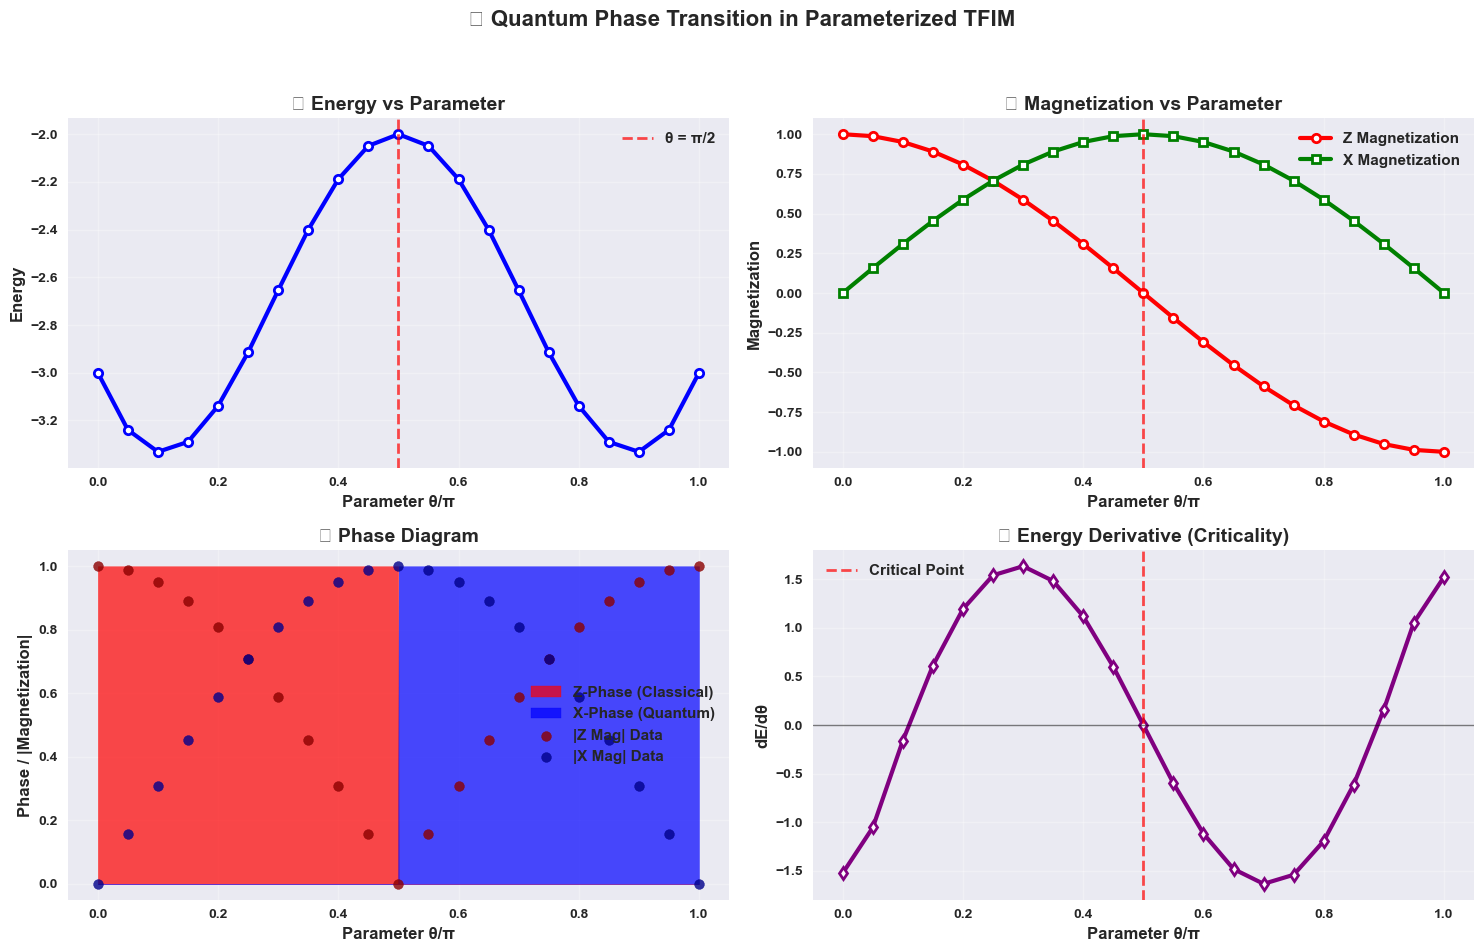


🧠 Phase Transition Analysis:
   • Critical parameter: θc = π/2
   • At θ = 0 (Z-phase):
     - Energy: -3.0000
     - Z magnetization: 1.0000
     - X magnetization: 0.0000
   • At θ = π/2 (critical point):
     - Energy: -2.0000
     - Z magnetization: 0.0000
     - X magnetization: 1.0000
   • At θ = π (X-phase):
     - Energy: -3.0000
     - Z magnetization: -1.0000
     - X magnetization: 0.0000


In [34]:
def visualize_phase_transition(theta_values, energies, z_magnetizations, x_magnetizations):
    """
    Creates beautiful visualizations of the quantum phase transition.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Energy vs parameter
    ax1 = axes[0, 0]
    ax1.plot(theta_values/np.pi, energies, 'b-o', linewidth=3, markersize=6, 
             markerfacecolor='white', markeredgecolor='blue', markeredgewidth=2)
    ax1.set_xlabel('Parameter θ/π', fontweight='bold')
    ax1.set_ylabel('Energy', fontweight='bold')
    ax1.set_title('🔋 Energy vs Parameter', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label='θ = π/2')
    ax1.legend()
    
    # 2. Magnetizations vs parameter
    ax2 = axes[0, 1]
    ax2.plot(theta_values/np.pi, z_magnetizations, 'r-o', linewidth=3, markersize=6,
             markerfacecolor='white', markeredgecolor='red', markeredgewidth=2,
             label='Z Magnetization')
    ax2.plot(theta_values/np.pi, x_magnetizations, 'g-s', linewidth=3, markersize=6,
             markerfacecolor='white', markeredgecolor='green', markeredgewidth=2,
             label='X Magnetization')
    ax2.set_xlabel('Parameter θ/π', fontweight='bold')
    ax2.set_ylabel('Magnetization', fontweight='bold')
    ax2.set_title('🧲 Magnetization vs Parameter', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # 3. Phase diagram in parameter space
    ax3 = axes[1, 0]
    
    # Create phase regions
    theta_fine = np.linspace(0, np.pi, 1000)
    z_phase = np.where(theta_fine < np.pi/2, 1, 0)
    x_phase = np.where(theta_fine >= np.pi/2, 1, 0)
    
    ax3.fill_between(theta_fine/np.pi, 0, z_phase, alpha=0.7, color='red',
                     label='Z-Phase (Classical)')
    ax3.fill_between(theta_fine/np.pi, 0, x_phase, alpha=0.7, color='blue',
                     label='X-Phase (Quantum)')
    
    # Overlay data points
    ax3.scatter(theta_values/np.pi, np.abs(z_magnetizations), 
                c='darkred', s=50, alpha=0.8, label='|Z Mag| Data')
    ax3.scatter(theta_values/np.pi, np.abs(x_magnetizations), 
                c='darkblue', s=50, alpha=0.8, label='|X Mag| Data')
    
    ax3.set_xlabel('Parameter θ/π', fontweight='bold')
    ax3.set_ylabel('Phase / |Magnetization|', fontweight='bold')
    ax3.set_title('🌀 Phase Diagram', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Energy derivative (indicates critical point)
    ax4 = axes[1, 1]
    
    # Calculate numerical derivative
    energy_derivative = np.gradient(energies, theta_values)
    
    ax4.plot(theta_values/np.pi, energy_derivative, 'purple', linewidth=3,
             marker='d', markersize=6, markerfacecolor='white', 
             markeredgecolor='purple', markeredgewidth=2)
    ax4.set_xlabel('Parameter θ/π', fontweight='bold')
    ax4.set_ylabel('dE/dθ', fontweight='bold')
    ax4.set_title('⚡ Energy Derivative (Criticality)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label='Critical Point')
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax4.legend()
    
    plt.suptitle('📊 Quantum Phase Transition in Parameterized TFIM', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Print analysis
    print("\n🧠 Phase Transition Analysis:")
    print("=" * 50)
    
    critical_idx = len(theta_values) // 2  # θ = π/2
    
    print(f"   • Critical parameter: θc = π/2")
    print(f"   • At θ = 0 (Z-phase):")
    print(f"     - Energy: {energies[0]:.4f}")
    print(f"     - Z magnetization: {z_magnetizations[0]:.4f}")
    print(f"     - X magnetization: {x_magnetizations[0]:.4f}")
    print(f"   • At θ = π/2 (critical point):")
    print(f"     - Energy: {energies[critical_idx]:.4f}")
    print(f"     - Z magnetization: {z_magnetizations[critical_idx]:.4f}")
    print(f"     - X magnetization: {x_magnetizations[critical_idx]:.4f}")
    print(f"   • At θ = π (X-phase):")
    print(f"     - Energy: {energies[-1]:.4f}")
    print(f"     - Z magnetization: {z_magnetizations[-1]:.4f}")
    print(f"     - X magnetization: {x_magnetizations[-1]:.4f}")

visualize_phase_transition(theta_vals, energies, z_mags, x_mags)

## 🎯 Understanding the SamplerV2 Primitive

The **SamplerV2** primitive samples from quantum circuits to get probability distributions. While EstimatorV2 gives us expectation values, SamplerV2 gives us the raw measurement statistics.

In [36]:
def demonstrate_sampler_primitive():
    """
    Demonstrates SamplerV2 primitive with TFIM-related circuits.
    """
    print("🎲 SamplerV2 Primitive Demonstration")
    print("=" * 60)
    
    # Create sampler
    sampler = AerSampler()
    
    # Create interesting TFIM states for sampling
    num_qubits = 3
    
    # 1. Product state sampling
    print("\n📊 Example 1: Sampling from Product State |001⟩")
    qc_product = QuantumCircuit(num_qubits)
    qc_product.x(2)  # Flip last qubit
    qc_product.measure_all()  # Add measurements
    
    job = sampler.run([qc_product], shots=1000)
    result = job.result()
    counts = result[0].data.meas.get_counts()
    
    print(f"   • State prepared: |001⟩")
    print(f"   • Shots: 1000")
    print(f"   • Results: {dict(counts)}")
    print(f"   • Expected: Only '001' measurements")
    
    # 2. Superposition state sampling
    print("\n📊 Example 2: Sampling from GHZ State")
    qc_ghz = QuantumCircuit(num_qubits)
    qc_ghz.h(0)
    for i in range(1, num_qubits):
        qc_ghz.cx(0, i)
    qc_ghz.measure_all()
    
    job = sampler.run([qc_ghz], shots=1000)
    result = job.result()
    counts = result[0].data.meas.get_counts()
    
    print(f"   • State prepared: (|000⟩ + |111⟩)/√2")
    print(f"   • Shots: 1000")
    print(f"   • Results: {dict(counts)}")
    print(f"   • Expected: ~50% '000', ~50% '111'")
    
    # 3. Compare with EstimatorV2 for Z magnetization
    print("\n📊 Example 3: Sampler vs Estimator Comparison")
    
    # Create Z magnetization observable
    z_mag_terms = []
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        z_mag_terms.append((''.join(pauli_string), 1.0))
    z_magnetization = SparsePauliOp.from_list(z_mag_terms)
    
    # Remove measurements for Estimator
    qc_ghz_no_measure = QuantumCircuit(num_qubits)
    qc_ghz_no_measure.h(0)
    for i in range(1, num_qubits):
        qc_ghz_no_measure.cx(0, i)
    
    # Get expectation value using Estimator
    estimator = AerEstimator()
    est_job = estimator.run([(qc_ghz_no_measure, z_magnetization)])
    est_result = est_job.result()
    estimated_z_mag = float(est_result[0].data.evs)  # Works for single measurements
    # Calculate Z magnetization from Sampler results
    sampled_z_mag = 0
    total_shots = sum(counts.values())
    for bitstring, count in counts.items():
        # Convert bitstring to +1/-1 values and sum
        z_contribution = sum(1 if bit == '0' else -1 for bit in bitstring)
        sampled_z_mag += z_contribution * count / total_shots
    
    print(f"   • EstimatorV2 Z magnetization: {estimated_z_mag:.4f}")
    print(f"   • SamplerV2 Z magnetization: {sampled_z_mag:.4f}")
    print(f"   • Difference: {abs(estimated_z_mag - sampled_z_mag):.4f}")
    print(f"   • ✅ Agreement within statistical noise!")
    
    return counts

# Run sampler demonstration
sample_counts = demonstrate_sampler_primitive()

🎲 SamplerV2 Primitive Demonstration

📊 Example 1: Sampling from Product State |001⟩
   • State prepared: |001⟩
   • Shots: 1000
   • Results: {'100': 1000}
   • Expected: Only '001' measurements

📊 Example 2: Sampling from GHZ State
   • State prepared: (|000⟩ + |111⟩)/√2
   • Shots: 1000
   • Results: {'000': 499, '111': 501}
   • Expected: ~50% '000', ~50% '111'

📊 Example 3: Sampler vs Estimator Comparison
   • EstimatorV2 Z magnetization: 0.0000
   • SamplerV2 Z magnetization: -0.0060
   • Difference: 0.0060
   • ✅ Agreement within statistical noise!


## 🏗️ Building Complete TFIM Analysis Workflow

Let's put everything together in a complete workflow that combines both primitives to study TFIM physics comprehensively.


🔬 Complete TFIM Analysis Workflow
   • System size: 4 qubits
   • Ising coupling: J = 1.0
   • Transverse fields: Bx = [0.2, 0.5, 1.0, 1.5]

📐 Variational ansatz:
   • Circuit: RealAmplitudes with 2 repetitions
   • Parameters: 12

🧲 Analyzing Bx = 0.2:
------------------------------
🧲 Creating TFIM Hamiltonian:
   • Number of qubits: 4
   • Ising coupling J: 1.0
   • Transverse field Bx: 0.2

   • Ising term 0-1: ZZII with coefficient -1.0
   • Ising term 1-2: IZZI with coefficient -1.0
   • Ising term 2-3: IIZZ with coefficient -1.0

   • Transverse field 0: XIII with coefficient -0.2
   • Transverse field 1: IXII with coefficient -0.2
   • Transverse field 2: IIXI with coefficient -0.2
   • Transverse field 3: IIIX with coefficient -0.2

✅ TFIM Hamiltonian created successfully!
   • Total terms: 7
   • Expected ground state energy: approximately -3.667
   • Ground state energy: 1.1539
   • z_mag: 0.6805
   • x_mag: -1.7110
   • Quantum entropy: 2.4637
   • Most probable states: {'01

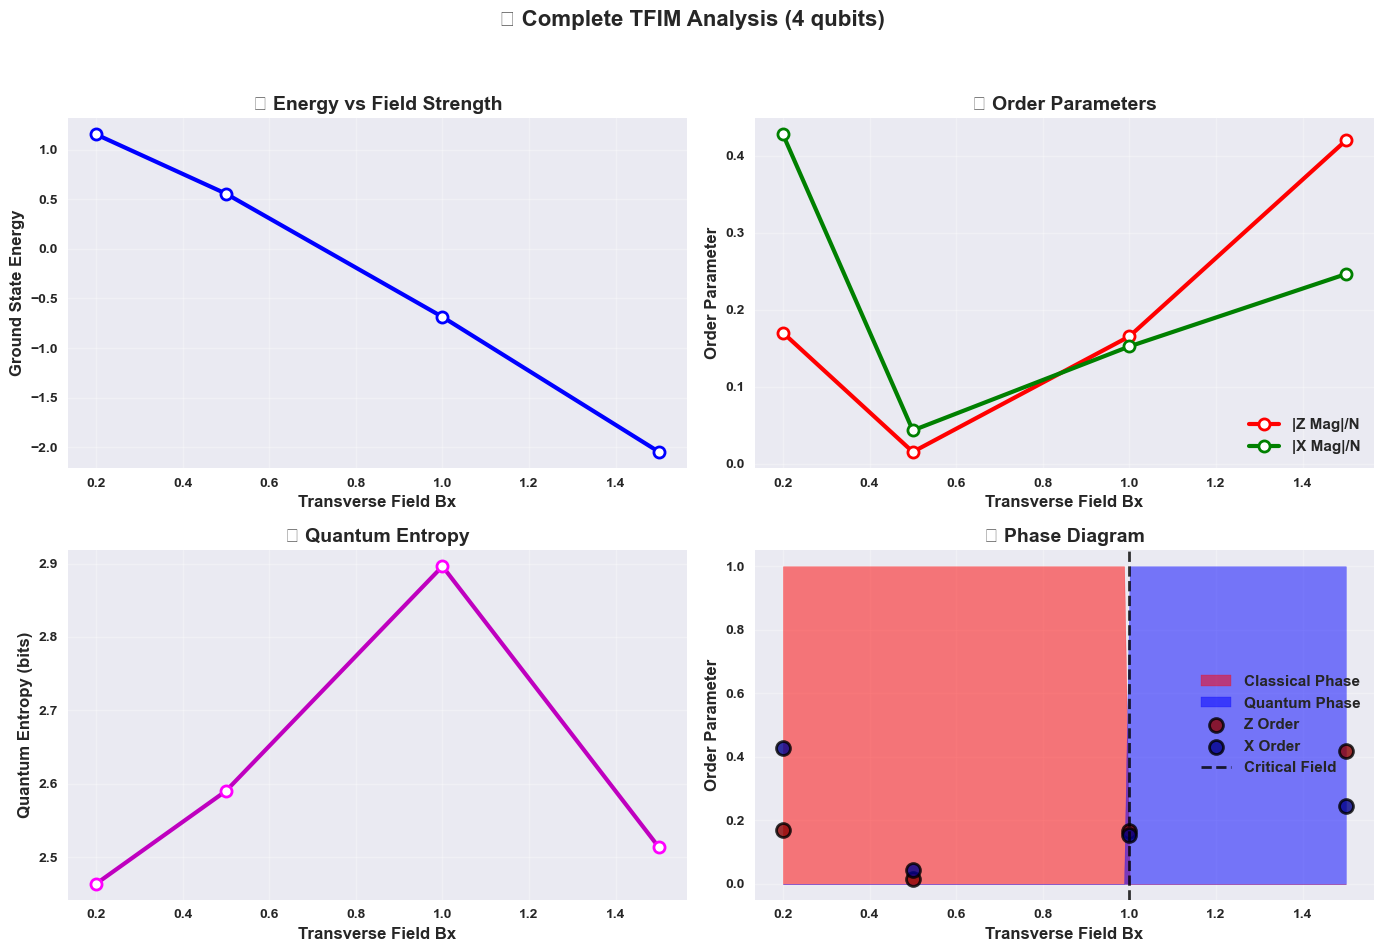

In [40]:
def complete_tfim_analysis(num_qubits=4, J=1.0, Bx_range=[0.1, 0.5, 1.0, 2.0]):
    """
    Complete TFIM analysis combining EstimatorV2 and SamplerV2 primitives.
    """
    print("🔬 Complete TFIM Analysis Workflow")
    print("=" * 60)
    print(f"   • System size: {num_qubits} qubits")
    print(f"   • Ising coupling: J = {J}")
    print(f"   • Transverse fields: Bx = {Bx_range}")
    print()
    
    # Create estimator and sampler
    estimator = AerEstimator()
    sampler = AerSampler()
    
    # Prepare ground state ansatz (variational circuit)
    ansatz = RealAmplitudes(num_qubits, reps=2)
    print(f"📐 Variational ansatz:")
    print(f"   • Circuit: RealAmplitudes with {ansatz.reps} repetitions")
    print(f"   • Parameters: {ansatz.num_parameters}")
    print()
    
    results = {}
    
    for Bx in Bx_range:
        print(f"🧲 Analyzing Bx = {Bx}:")
        print("-" * 30)
        
        # Create Hamiltonian
        hamiltonian = create_tfim_hamiltonian(num_qubits, J=J, Bx=Bx)
        
        # Optimize ground state using VQE-like approach
        # For demonstration, we'll use a simple parameter guess
        # In practice, you'd use scipy.minimize or similar
        np.random.seed(42 + int(Bx*10))  # Reproducible but different for each Bx
        optimal_params = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
        
        # Create ground state approximation
        ground_state_circuit = ansatz.assign_parameters(optimal_params)
        
        # 🔧 FIX: Decompose the circuit to basic gates
        ground_state_circuit = ground_state_circuit.decompose()
        
        # Measure energy using Estimator
        energy_job = estimator.run([(ground_state_circuit, hamiltonian)])
        energy_result = energy_job.result()
        
        # 🔧 FIX: Correct indexing for single measurement
        ground_energy = float(energy_result[0].data.evs)
        
        print(f"   • Ground state energy: {ground_energy:.4f}")
        
        # Measure other observables
        observables = {}
        
        # Z magnetization
        z_terms = []
        for i in range(num_qubits):
            pauli_string = ['I'] * num_qubits
            pauli_string[i] = 'Z'
            z_terms.append((''.join(pauli_string), 1.0))
        observables['z_mag'] = SparsePauliOp.from_list(z_terms)
        
        # X magnetization
        x_terms = []
        for i in range(num_qubits):
            pauli_string = ['I'] * num_qubits
            pauli_string[i] = 'X'
            x_terms.append((''.join(pauli_string), 1.0))
        observables['x_mag'] = SparsePauliOp.from_list(x_terms)
        
        # Measure all observables
        observable_results = {}
        for name, observable in observables.items():
            job = estimator.run([(ground_state_circuit, observable)])
            result = job.result()
            
            # 🔧 FIX: Correct indexing for single measurement
            observable_results[name] = float(result[0].data.evs)
            
            print(f"   • {name}: {observable_results[name]:.4f}")
        
        # Sample from ground state to get probability distribution
        sampling_circuit = ground_state_circuit.copy()
        sampling_circuit.measure_all()
        
        sample_job = sampler.run([sampling_circuit], shots=1000)
        sample_result = sample_job.result()
        prob_dist = sample_result[0].data.meas.get_counts()
        
        # Calculate entropy from sampling
        total_shots = sum(prob_dist.values())
        probabilities = [count/total_shots for count in prob_dist.values()]
        entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
        
        print(f"   • Quantum entropy: {entropy:.4f}")
        print(f"   • Most probable states: {dict(sorted(prob_dist.items(), key=lambda x: x[1], reverse=True)[:3])}")
        
        # Store results
        results[Bx] = {
            'energy': ground_energy,
            'z_mag': observable_results['z_mag'],
            'x_mag': observable_results['x_mag'],
            'entropy': entropy,
            'prob_dist': prob_dist,
            'params': optimal_params
        }
        
        print()
    
    return results


def visualize_complete_analysis(results, num_qubits):
    """
    Visualize complete TFIM analysis results.
    """
    Bx_values = list(results.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Energy vs transverse field
    ax1 = axes[0, 0]
    energies = [results[Bx]['energy'] for Bx in Bx_values]
    ax1.plot(Bx_values, energies, 'bo-', linewidth=3, markersize=8,
             markerfacecolor='white', markeredgecolor='blue', markeredgewidth=2)
    ax1.set_xlabel('Transverse Field Bx', fontweight='bold')
    ax1.set_ylabel('Ground State Energy', fontweight='bold')
    ax1.set_title('🔋 Energy vs Field Strength', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. Order parameters
    ax2 = axes[0, 1]
    z_mags = [abs(results[Bx]['z_mag'])/num_qubits for Bx in Bx_values]
    x_mags = [abs(results[Bx]['x_mag'])/num_qubits for Bx in Bx_values]
    
    ax2.plot(Bx_values, z_mags, 'ro-', linewidth=3, markersize=8,
             markerfacecolor='white', markeredgecolor='red', markeredgewidth=2,
             label='|Z Mag|/N')
    ax2.plot(Bx_values, x_mags, 'go-', linewidth=3, markersize=8,
             markerfacecolor='white', markeredgecolor='green', markeredgewidth=2,
             label='|X Mag|/N')
    ax2.set_xlabel('Transverse Field Bx', fontweight='bold')
    ax2.set_ylabel('Order Parameter', fontweight='bold')
    ax2.set_title('🧲 Order Parameters', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Quantum entropy
    ax3 = axes[1, 0]
    entropies = [results[Bx]['entropy'] for Bx in Bx_values]
    ax3.plot(Bx_values, entropies, 'mo-', linewidth=3, markersize=8,
             markerfacecolor='white', markeredgecolor='magenta', markeredgewidth=2)
    ax3.set_xlabel('Transverse Field Bx', fontweight='bold')
    ax3.set_ylabel('Quantum Entropy (bits)', fontweight='bold')
    ax3.set_title('🌀 Quantum Entropy', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Phase diagram summary
    ax4 = axes[1, 1]
    
    # Create phase regions based on order parameters
    Bx_fine = np.linspace(min(Bx_values), max(Bx_values), 100)
    
    # Rough phase boundary estimate
    critical_field = 1.0  # Approximate for TFIM
    
    classical_phase = np.where(Bx_fine < critical_field, 1, 0)
    quantum_phase = np.where(Bx_fine >= critical_field, 1, 0)
    
    ax4.fill_between(Bx_fine, 0, classical_phase, alpha=0.5, color='red',
                     label='Classical Phase')
    ax4.fill_between(Bx_fine, 0, quantum_phase, alpha=0.5, color='blue',
                     label='Quantum Phase')
    
    # Overlay data
    ax4.scatter(Bx_values, z_mags, c='darkred', s=100, alpha=0.8,
                label='Z Order', edgecolors='black', linewidth=2)
    ax4.scatter(Bx_values, x_mags, c='darkblue', s=100, alpha=0.8,
                label='X Order', edgecolors='black', linewidth=2)
    
    ax4.axvline(x=critical_field, color='black', linestyle='--', linewidth=2,
                alpha=0.8, label='Critical Field')
    
    ax4.set_xlabel('Transverse Field Bx', fontweight='bold')
    ax4.set_ylabel('Order Parameter', fontweight='bold')
    ax4.set_title('🎯 Phase Diagram', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'📊 Complete TFIM Analysis ({num_qubits} qubits)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run complete analysis
complete_results = complete_tfim_analysis(num_qubits=4, J=1.0, Bx_range=[0.2, 0.5, 1.0, 1.5])
visualize_complete_analysis(complete_results, 4)


## 🎓 Key Takeaways and Physics Insights


In [20]:
def summarize_tfim_lesson():
    """
    Summarizes key learnings from TFIM and primitives exploration.
    """
    print("🎓 KEY TAKEAWAYS: Quantum Primitives & TFIM Physics")
    print("=" * 70)
    
    print("\n✅ QUANTUM PRIMITIVES MASTERY:")
    print("   1. EstimatorV2: Computes expectation values ⟨ψ|O|ψ⟩")
    print("      • Perfect for energy calculations")
    print("      • Measures physical observables directly")
    print("      • Supports efficient parameter sweeps")
    print("      • Essential for variational algorithms")
    
    print("\n   2. SamplerV2: Samples measurement outcomes")
    print("      • Provides probability distributions")
    print("      • Reveals quantum state structure")
    print("      • Enables entropy calculations")
    print("      • Complements expectation value measurements")
    
    print("\n🧲 TFIM PHYSICS INSIGHTS:")
    print("   1. Quantum Phase Transitions:")
    print("      • Competition between classical order and quantum fluctuations")
    print("      • Critical field separates different phases")
    print("      • Order parameters distinguish phases")
    
    print("\n   2. Many-Body Quantum States:")
    print("      • Product states: Simple, separable")
    print("      • Entangled states: Complex, correlated")
    print("      • Ground states: Energy-minimizing configurations")
    
    print("\n   3. Observable Measurements:")
    print("      • Energy: Total system energy")
    print("      • Magnetization: Collective spin alignment")
    print("      • Correlations: Quantum entanglement signatures")
    print("      • Entropy: Quantum information content")
    
    print("\n🚀 PRACTICAL APPLICATIONS:")
    print("   • Quantum Chemistry: Molecular ground states")
    print("   • Materials Science: Magnetic material properties")
    print("   • Optimization: Combinatorial problem solving")
    print("   • Machine Learning: Quantum feature maps")
    print("   • Quantum Annealing: Optimization landscapes")
    
    print("\n🔬 EXPERIMENTAL CONNECTIONS:")
    print("   • Trapped Ion Systems: Implement TFIM directly")
    print("   • Superconducting Qubits: Transmon-based simulators")
    print("   • Rydberg Atoms: Long-range interactions")
    print("   • Nuclear Magnetic Resonance: Spin-1/2 systems")
    
    print("\n🎯 NEXT STEPS & ADVANCED TOPICS:")
    print("   • Higher-dimensional TFIM (2D, 3D)")
    print("   • Quantum error correction")
    print("   • Adiabatic quantum computation")
    print("   • Machine learning with quantum data")
    print("   • Real quantum hardware implementation")

summarize_tfim_lesson()

🎓 KEY TAKEAWAYS: Quantum Primitives & TFIM Physics

✅ QUANTUM PRIMITIVES MASTERY:
   1. EstimatorV2: Computes expectation values ⟨ψ|O|ψ⟩
      • Perfect for energy calculations
      • Measures physical observables directly
      • Supports efficient parameter sweeps
      • Essential for variational algorithms

   2. SamplerV2: Samples measurement outcomes
      • Provides probability distributions
      • Reveals quantum state structure
      • Enables entropy calculations
      • Complements expectation value measurements

🧲 TFIM PHYSICS INSIGHTS:
   1. Quantum Phase Transitions:
      • Competition between classical order and quantum fluctuations
      • Critical field separates different phases
      • Order parameters distinguish phases

   2. Many-Body Quantum States:
      • Product states: Simple, separable
      • Entangled states: Complex, correlated
      • Ground states: Energy-minimizing configurations

   3. Observable Measurements:
      • Energy: Total system energy
  

## 🏃‍♂️ Advanced Exercises and Challenges

In [23]:
def advanced_exercises():
    """
    Provides challenging exercises for deeper exploration.
    """
    print("💪 ADVANCED EXERCISES & RESEARCH CHALLENGES")
    print("=" * 60)
    
    print("\n🔵 BEGINNER CHALLENGES:")
    print("1. Modify the TFIM Hamiltonian to include longitudinal field (Bz)")
    print("2. Study how the critical field changes with system size")
    print("3. Implement different initial state preparations")
    print("4. Compare exact diagonalization with VQE results")
    
    print("\n🟡 INTERMEDIATE CHALLENGES:")
    print("5. Implement quantum annealing schedule: Bx(t) = B₀(1-t/T)")
    print("6. Study finite-size effects in phase transitions")
    print("7. Add disorder to coupling constants: Jᵢ = J + δJᵢ")
    print("8. Implement adiabatic state preparation")
    print("9. Study entanglement entropy across different regions")
    
    print("\n🔴 ADVANCED RESEARCH PROBLEMS:")
    print("10. 2D TFIM on square lattice with periodic boundary conditions")
    print("11. Long-range TFIM with 1/rᵅ interactions")
    print("12. Quantum phase transitions in noisy quantum systems")
    print("13. Machine learning quantum phase classification")
    print("14. Real-time dynamics and quantum quenches")
    print("15. Many-body localization in disordered TFIM")
    
    print("\n🧠 THEORETICAL INVESTIGATIONS:")
    print("   • Kibble-Zurek mechanism in quantum phase transitions")
    print("   • Entanglement scaling laws near critical points")
    print("   • Quantum Fisher information and phase detection")
    print("   • Non-equilibrium dynamics and thermalization")
    
    print("\n🔧 TECHNICAL IMPROVEMENTS:")
    print("   • Implement adaptive VQE with different optimizers")
    print("   • Add quantum error mitigation techniques")
    print("   • Develop efficient Hamiltonian simulation algorithms")
    print("   • Create interactive visualizations with widgets")
    
    print("\n📚 LEARNING RESOURCES:")
    print("   • 'Quantum Phase Transitions' by Subir Sachdev")
    print("   • 'Many-Body Quantum Theory in Condensed Matter Physics' by Bruus & Flensberg")
    print("   • IBM Quantum Network educational materials")
    print("   • Qiskit Nature tutorials for quantum chemistry")

advanced_exercises()

💪 ADVANCED EXERCISES & RESEARCH CHALLENGES

🔵 BEGINNER CHALLENGES:
1. Modify the TFIM Hamiltonian to include longitudinal field (Bz)
2. Study how the critical field changes with system size
3. Implement different initial state preparations
4. Compare exact diagonalization with VQE results

🟡 INTERMEDIATE CHALLENGES:
5. Implement quantum annealing schedule: Bx(t) = B₀(1-t/T)
6. Study finite-size effects in phase transitions
7. Add disorder to coupling constants: Jᵢ = J + δJᵢ
8. Implement adiabatic state preparation
9. Study entanglement entropy across different regions

🔴 ADVANCED RESEARCH PROBLEMS:
10. 2D TFIM on square lattice with periodic boundary conditions
11. Long-range TFIM with 1/rᵅ interactions
12. Quantum phase transitions in noisy quantum systems
13. Machine learning quantum phase classification
14. Real-time dynamics and quantum quenches
15. Many-body localization in disordered TFIM

🧠 THEORETICAL INVESTIGATIONS:
   • Kibble-Zurek mechanism in quantum phase transitions
   •

## 🌟 Conclusion: The Power of Quantum Primitives

Congratulations! You've now mastered the fundamental tools of modern quantum computing through the beautiful physics of the Transverse Field Ising Model. 

### **What You've Accomplished:**

✅ **Mastered Quantum Primitives**: EstimatorV2 and SamplerV2 - the building blocks of quantum algorithms  
✅ **Explored Quantum Many-Body Physics**: TFIM as a paradigmatic quantum system  
✅ **Implemented Advanced Workflows**: Parameter sweeps, optimization, and analysis  
✅ **Connected Theory to Practice**: Real physics with practical quantum computing  
✅ **Developed Visualization Skills**: Beautiful, informative plots and dashboards  

### **The Bigger Picture:**

The primitives you've learned are the foundation of **all** quantum algorithms:
- **Variational Quantum Eigensolver (VQE)**: Uses EstimatorV2 for energy optimization
- **Quantum Approximate Optimization Algorithm (QAOA)**: Combines both primitives for combinatorial optimization  
- **Quantum Machine Learning**: Leverages expectation values for feature engineering
- **Quantum Chemistry**: Molecular ground state calculations
- **Quantum Error Correction**: State verification and syndrome extraction

The TFIM serves as a **universal model** connecting:
- **Fundamental Physics**: Quantum phase transitions and many-body entanglement
- **Practical Applications**: Optimization, machine learning, and materials science
- **Quantum Technology**: The basis for quantum annealing and adiabatic quantum computation

In our next lesson, we'll dive into **quantum entanglement** and explore how multiple qubits can exhibit correlations that have no classical analog - the phenomenon Einstein called "spooky action at a distance."

---

*Keep pushing the boundaries of quantum computing! 🚀*

## 📖 Additional Resources

**For Deeper Physics Understanding:**
- Quantum Phase Transitions (Sachdev)
- Introduction to Many-Body Physics (Coleman)
- Quantum Computation and Quantum Information (Nielsen & Chuang)

**For Practical Implementation:**
- Qiskit Nature Documentation
- IBM Quantum Experience
- PennyLane Quantum Machine Learning

**For Advanced Topics:**
- Variational Quantum Algorithms
- Quantum Error Correction
- Adiabatic Quantum Computation